In [1]:
import time
import math
from scipy.stats import gmean
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import seaborn as sns
import ast

In [2]:
adjClose1 = pd.read_csv("MIE377_AssetPrices_1.csv", index_col=0)
factorRet1 = pd.read_csv("MIE377_FactorReturns_1.csv", index_col=0)

adjClose2 = pd.read_csv("MIE377_AssetPrices_2.csv", index_col=0)
factorRet2 = pd.read_csv("MIE377_FactorReturns_2.csv", index_col=0)

adjClose3 = pd.read_csv("MIE377_AssetPrices_3.csv", index_col=0)
factorRet3 = pd.read_csv("MIE377_FactorReturns_3.csv", index_col=0)

adj = [adjClose1, adjClose2, adjClose3]
fact = [factorRet1, factorRet2, factorRet3]

dataset_list = [] 
Us_list = []
Ks_list = []
sr_list = []
to_list = []
et_list = []

counter = 0

In [3]:
Us = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Ks = [1, 2, 3, 4, 5, 6, 7]

In [4]:
for i in range(len(adj)):
    for U in Us:
        for K in Ks:
            print(U, K)
            adjClose = adj[i]
            factorRet = fact[i]

            adjClose.index = pd.to_datetime(adjClose.index)
            factorRet.index = pd.to_datetime(factorRet.index)

            # Initial budget to invest ($100,000)
            initialVal = 100000

            # Length of investment period (in months)
            investPeriod = 6

            # divide the factor returns by  100
            factorRet = factorRet/100

            #rf and factor returns
            riskFree = factorRet['RF']
            factorRet = factorRet.loc[:,factorRet.columns != 'RF'];

            #Identify the tickers and the dates
            tickers = adjClose.columns
            dates   = factorRet.index

            # Calculate the stocks monthly excess returns
            # pct change and drop the first null observation
            returns = adjClose.pct_change(1).iloc[1:, :]
            returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
            # Align the price table to the asset and factor returns tables by discarding the first observation.
            adjClose = adjClose.iloc[1:,:]

            assert adjClose.index[0] == returns.index[0]
            assert adjClose.index[0] == factorRet.index[0]

            # Start of out-of-sample test period
            testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

            #End of the first investment period
            testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

            # End of calibration period
            calEnd = testStart -  pd.offsets.DateOffset(days = 1)

            # Total number of investment periods
            NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

            # Number of assets
            n  = len(tickers)

            # Preallocate space for the portfolio weights (x0 will be used to calculate
            # the turnover rate)
            x  = np.zeros([n, NoPeriods])
            x0 = np.zeros([n, NoPeriods])

            # Preallocate space for the portfolio per period value and turnover
            currentVal = np.zeros([NoPeriods, 1])
            turnover   = np.zeros([NoPeriods, 1])

            #Initiate counter for the number of observations per investment period
            toDay = 0

            # Measure runtime: start the clock
            start_time = time.time()

            # Empty list to measure the value of the portfolio over the period
            portfValue = []

            for t in range(NoPeriods):
                # Subset the returns and factor returns corresponding to the current calibration period.
                periodReturns = returns[returns.index <= calEnd]
                periodFactRet = factorRet[factorRet.index <= calEnd]

                current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
                currentPrices = adjClose[current_price_idx]

                # Subset the prices corresponding to the current out-of-sample test period.
                periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
                periodPrices = adjClose[periodPrices_idx]

                assert len(periodPrices) == investPeriod
                assert len(currentPrices) == 1
                # Set the initial value of the portfolio or update the portfolio value
                if t == 0:
                    currentVal[0] = initialVal
                else:
                    currentVal[t] = currentPrices @  NoShares.values.T
                    #Store the current asset weights (before optimization takes place)
                    x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

                #----------------------------------------------------------------------
                # Portfolio optimization
                # You must write code your own algorithmic trading function
                # The project function is in the services folder
                # Take in the period returns and period factor returns and produce
                # an allocation
                #----------------------------------------------------------------------
                x[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], U, K)

                #Calculate the turnover rate
                if t > 0:
                    turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

                # Number of shares your portfolio holds per stock
                NoShares = x[:,t]*currentVal[t]/currentPrices

                # Update counter for the number of observations per investment period
                fromDay = toDay
                toDay   = toDay + len(periodPrices)

                # Weekly portfolio value during the out-of-sample window
                portfValue.append(periodPrices@ NoShares.values.T)

                # Update your calibration and out-of-sample test periods
                testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
                testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
                calEnd    = testStart - pd.offsets.DateOffset(days=1)

            portfValue = pd.concat(portfValue, axis = 0)
            end_time = time.time()

            #--------------------------------------------------------------------------
            # 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
            #-----------------------------------------------------------------------
            # Calculate the observed portfolio returns
            portfRets = portfValue.pct_change(1).iloc[1:,:]

            # Calculate the portfolio excess returns
            portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

            # Calculate the portfolio Sharpe ratio
            SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

            # Calculate the average turnover rate
            avgTurnover = np.mean(turnover[1:])

            dataset_list.append(i+1)
            Us_list.append(U)
            Ks_list.append(K)
            sr_list.append(SR[0])
            to_list.append(avgTurnover)
            et_list.append(end_time - start_time)

            counter += 1
            print('Iteration {} done\n'.format(counter))

1 1
Restricted license - for non-production use only - expires 2025-11-24


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 1 done

1 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 2 done

1 3
Iteration 3 done

1 4
Iteration 4 done

1 5
Iteration 5 done

1 6
Iteration 6 done

1 7
Iteration 7 done

2 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 8 done

2 2
Iteration 9 done

2 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 10 done

2 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 11 done

2 5
Iteration 12 done

2 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 13 done

2 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 14 done

3 1
Iteration 15 done

3 2
Iteration 16 done

3 3
Iteration 17 done

3 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 18 done

3 5
Iteration 19 done

3 6
Iteration 20 done

3 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 21 done

4 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 22 done

4 2
Iteration 23 done

4 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 24 done

4 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 25 done

4 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 26 done

4 6
Iteration 27 done

4 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 28 done

5 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 29 done

5 2
Iteration 30 done

5 3
Iteration 31 done

5 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 32 done

5 5
Iteration 33 done

5 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 34 done

5 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 35 done

6 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 36 done

6 2
Iteration 37 done

6 3
Iteration 38 done

6 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 39 done

6 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 40 done

6 6
Iteration 41 done

6 7
Iteration 42 done

7 1
Iteration 43 done

7 2
Iteration 44 done

7 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 45 done

7 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 46 done

7 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 47 done

7 6
Iteration 48 done

7 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 49 done

8 1
Iteration 50 done

8 2
Iteration 51 done

8 3
Iteration 52 done

8 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 53 done

8 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 54 done

8 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 55 done

8 7
Iteration 56 done

9 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 57 done

9 2
Iteration 58 done

9 3
Iteration 59 done

9 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 60 done

9 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 61 done

9 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 62 done

9 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 63 done

10 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 64 done

10 2
Iteration 65 done

10 3
Iteration 66 done

10 4
Iteration 67 done

10 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 68 done

10 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 69 done

10 7
Iteration 70 done

11 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 71 done

11 2
Iteration 72 done

11 3
Iteration 73 done

11 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 74 done

11 5
Iteration 75 done

11 6
Iteration 76 done

11 7
Iteration 77 done

12 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 78 done

12 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 79 done

12 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 80 done

12 4
Iteration 81 done

12 5
Iteration 82 done

12 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 83 done

12 7
Iteration 84 done

13 1
Iteration 85 done

13 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 86 done

13 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 87 done

13 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 88 done

13 5
Iteration 89 done

13 6
Iteration 90 done

13 7
Iteration 91 done

14 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 92 done

14 2
Iteration 93 done

14 3
Iteration 94 done

14 4
Iteration 95 done

14 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 96 done

14 6
Iteration 97 done

14 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 98 done

15 1
Iteration 99 done

15 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 100 done

15 3
Iteration 101 done

15 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 102 done

15 5
Iteration 103 done

15 6
Iteration 104 done

15 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 105 done

1 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 106 done

1 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 107 done

1 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 108 done

1 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 109 done

1 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 110 done

1 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 111 done

1 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 112 done

2 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 113 done

2 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 114 done

2 3
Iteration 115 done

2 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 116 done

2 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 117 done

2 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 118 done

2 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 119 done

3 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 120 done

3 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 121 done

3 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 122 done

3 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 123 done

3 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 124 done

3 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 125 done

3 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 126 done

4 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 127 done

4 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 128 done

4 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 129 done

4 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 130 done

4 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 131 done

4 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 132 done

4 7
Iteration 133 done

5 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 134 done

5 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 135 done

5 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 136 done

5 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 137 done

5 5
Iteration 138 done

5 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 139 done

5 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 140 done

6 1
Iteration 141 done

6 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 142 done

6 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 143 done

6 4
Iteration 144 done

6 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 145 done

6 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 146 done

6 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 147 done

7 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 148 done

7 2
Iteration 149 done

7 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 150 done

7 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 151 done

7 5
Iteration 152 done

7 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 153 done

7 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 154 done

8 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 155 done

8 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 156 done

8 3
Iteration 157 done

8 4
Iteration 158 done

8 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 159 done

8 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 160 done

8 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 161 done

9 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 162 done

9 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 163 done

9 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 164 done

9 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 165 done

9 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 166 done

9 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 167 done

9 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 168 done

10 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 169 done

10 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 170 done

10 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 171 done

10 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 172 done

10 5
Iteration 173 done

10 6
Iteration 174 done

10 7
Iteration 175 done

11 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 176 done

11 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 177 done

11 3
Iteration 178 done

11 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 179 done

11 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 180 done

11 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 181 done

11 7
Iteration 182 done

12 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 183 done

12 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 184 done

12 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 185 done

12 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 186 done

12 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 187 done

12 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 188 done

12 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 189 done

13 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 190 done

13 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 191 done

13 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 192 done

13 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 193 done

13 5
Iteration 194 done

13 6
Iteration 195 done

13 7
Iteration 196 done

14 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 197 done

14 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 198 done

14 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 199 done

14 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 200 done

14 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 201 done

14 6
Iteration 202 done

14 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 203 done

15 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 204 done

15 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 205 done

15 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 206 done

15 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 207 done

15 5
Iteration 208 done

15 6
Iteration 209 done

15 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 210 done

1 1
Iteration 211 done

1 2
Iteration 212 done

1 3
Iteration 213 done

1 4
Iteration 214 done

1 5
Iteration 215 done

1 6
Iteration 216 done

1 7
Iteration 217 done

2 1
Iteration 218 done

2 2
Iteration 219 done

2 3
Iteration 220 done

2 4
Iteration 221 done

2 5
Iteration 222 done

2 6
Iteration 223 done

2 7
Iteration 224 done

3 1
Iteration 225 done

3 2
Iteration 226 done

3 3
Iteration 227 done

3 4
Iteration 228 done

3 5
Iteration 229 done

3 6
Iteration 230 done

3 7
Iteration 231 done

4 1
Iteration 232 done

4 2
Iteration 233 done

4 3
Iteration 234 done

4 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 235 done

4 5
Iteration 236 done

4 6
Iteration 237 done

4 7
Iteration 238 done

5 1
Iteration 239 done

5 2
Iteration 240 done

5 3
Iteration 241 done

5 4
Iteration 242 done

5 5
Iteration 243 done

5 6
Iteration 244 done

5 7
Iteration 245 done

6 1


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 246 done

6 2
Iteration 247 done

6 3
Iteration 248 done

6 4
Iteration 249 done

6 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 250 done

6 6
Iteration 251 done

6 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 252 done

7 1
Iteration 253 done

7 2
Iteration 254 done

7 3
Iteration 255 done

7 4
Iteration 256 done

7 5
Iteration 257 done

7 6
Iteration 258 done

7 7
Iteration 259 done

8 1
Iteration 260 done

8 2
Iteration 261 done

8 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 262 done

8 4
Iteration 263 done

8 5
Iteration 264 done

8 6
Iteration 265 done

8 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 266 done

9 1
Iteration 267 done

9 2
Iteration 268 done

9 3
Iteration 269 done

9 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 270 done

9 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 271 done

9 6
Iteration 272 done

9 7
Iteration 273 done

10 1
Iteration 274 done

10 2
Iteration 275 done

10 3
Iteration 276 done

10 4
Iteration 277 done

10 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 278 done

10 6
Iteration 279 done

10 7
Iteration 280 done

11 1
Iteration 281 done

11 2
Iteration 282 done

11 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 283 done

11 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 284 done

11 5
Iteration 285 done

11 6
Iteration 286 done

11 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 287 done

12 1
Iteration 288 done

12 2
Iteration 289 done

12 3
Iteration 290 done

12 4
Iteration 291 done

12 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 292 done

12 6
Iteration 293 done

12 7
Iteration 294 done

13 1
Iteration 295 done

13 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 296 done

13 3
Iteration 297 done

13 4
Iteration 298 done

13 5
Iteration 299 done

13 6
Iteration 300 done

13 7


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 301 done

14 1
Iteration 302 done

14 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 303 done

14 3


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 304 done

14 4
Iteration 305 done

14 5


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 306 done

14 6


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 307 done

14 7
Iteration 308 done

15 1
Iteration 309 done

15 2


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 310 done

15 3
Iteration 311 done

15 4


c:\Users\steph\miniconda3\envs\svmmvo-project2\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Iteration 312 done

15 5
Iteration 313 done

15 6
Iteration 314 done

15 7
Iteration 315 done



In [5]:
df = pd.DataFrame({'Dataset': dataset_list, 
                   'U': Us_list,
                   'K': Ks_list, 
                   'Sharpe Ratio': sr_list, 
                   'Average Turnover': to_list, 
                   'Elapsed Time': et_list})

df.to_csv('results_rf_bss_UK.csv')

In [6]:
# df = pd.read_csv('results1.csv')
# df = df.drop('Unnamed: 0', axis=1)
# df['Parameters'] = df['Parameters'].apply(ast.literal_eval)

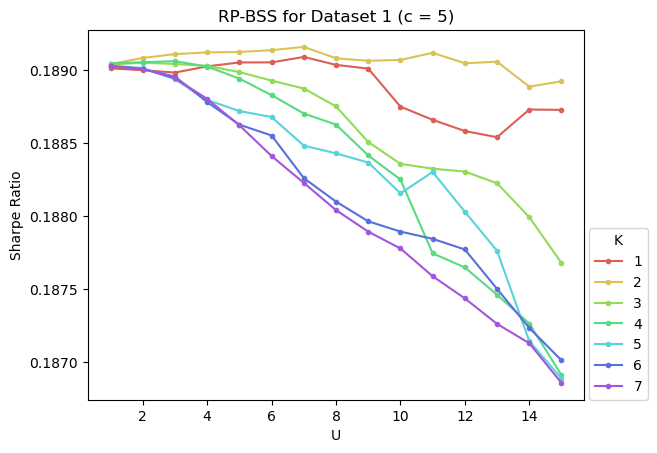

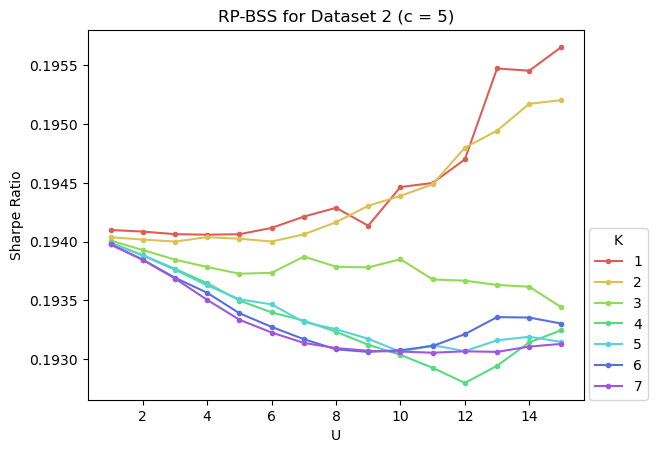

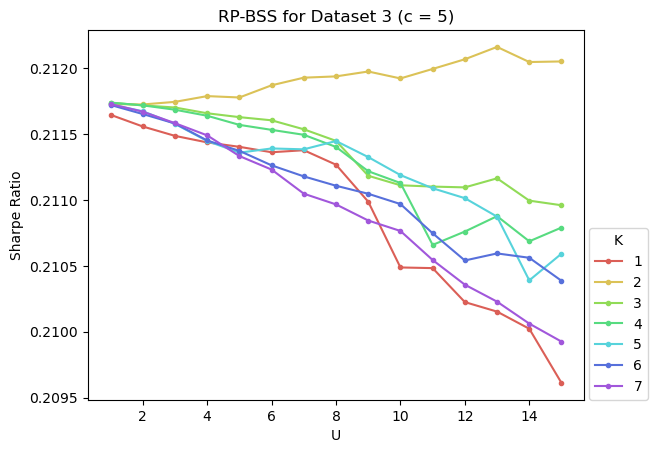

In [6]:
clrs = sns.color_palette('hls', n_colors=len(Ks)+1)

for i in range(1, 4):
    j = 0
    for K in Ks:
        sub_df = df[(df['Dataset'] == i) & (df['K'] == K)]
        plt.plot(sub_df['U'], sub_df['Sharpe Ratio'], '.-', color=clrs[j], label=K)
        j += 1

    plt.legend(title='K', loc=(1.01, 0))
    plt.title('RP-BSS for Dataset {} (c = 5)'.format(i))
    plt.xlabel('U')
    plt.ylabel('Sharpe Ratio')

    plt.show()

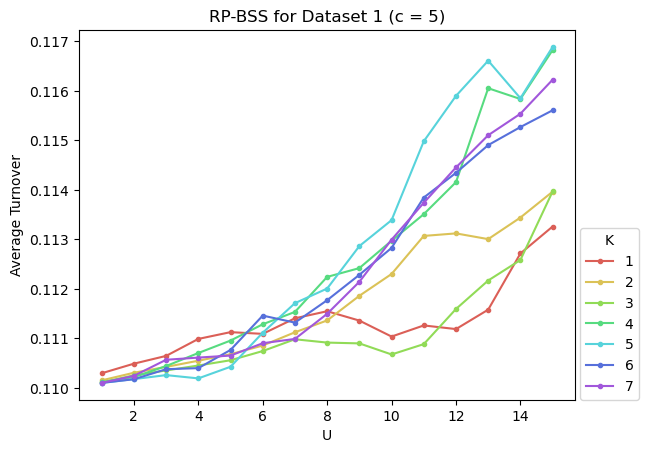

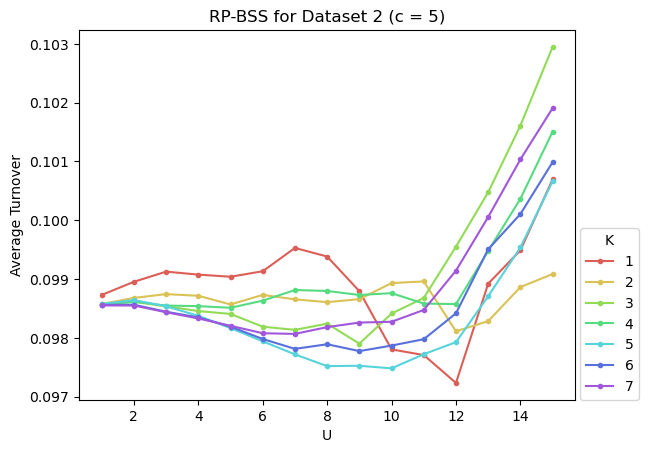

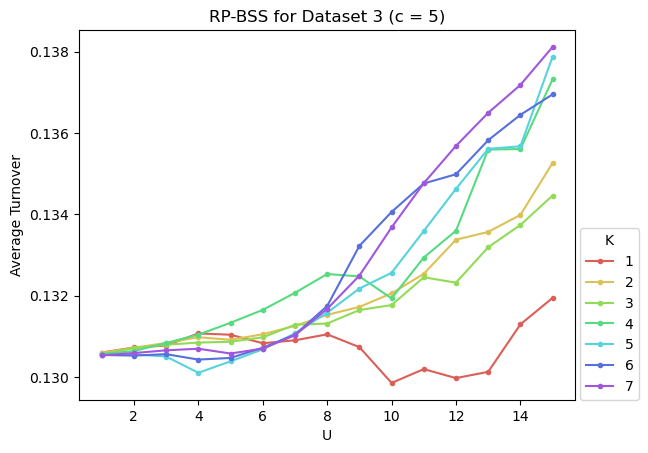

In [7]:
clrs = sns.color_palette('hls', n_colors=len(Ks)+1)

for i in range(1, 4):
    j = 0
    for K in Ks:
        sub_df = df[(df['Dataset'] == i) & (df['K'] == K)]
        plt.plot(sub_df['U'], sub_df['Average Turnover'], '.-', color=clrs[j], label=K)
        j += 1

    plt.legend(title='K', loc=(1.01, 0))
    plt.title('RP-BSS for Dataset {} (c = 5)'.format(i))
    plt.xlabel('U')
    plt.ylabel('Average Turnover')

    plt.show()

In [ ]:
# c = 1 for all below

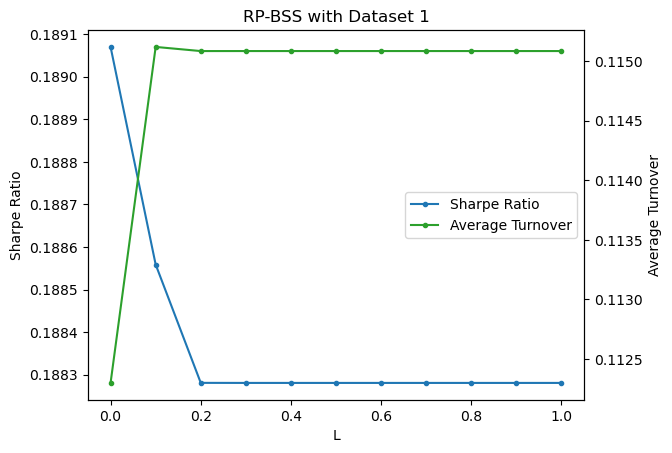

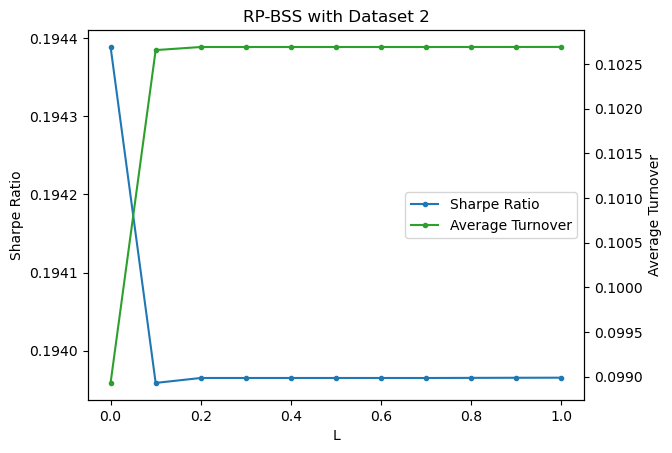

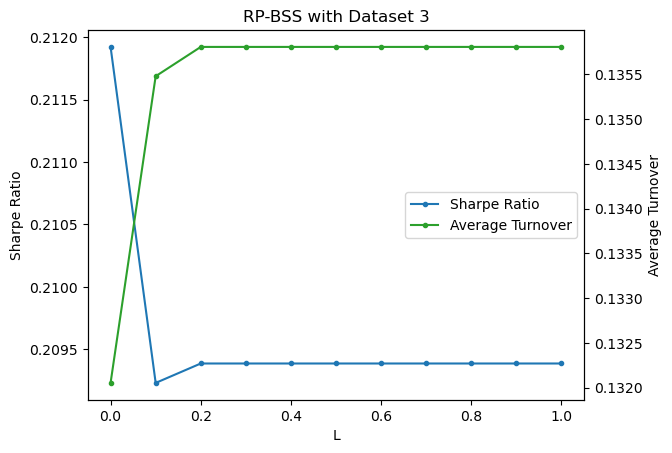

In [8]:
for i in range(1, 4):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sub_df = df[(df['Dataset'] == i)]

    ax1.plot(sub_df['Parameters'], sub_df['Sharpe Ratio'], '.-', color='tab:blue', label='Sharpe Ratio')
    ax1.plot([], [], '.-', color='tab:green', label='Average Turnover')
    ax2.plot(sub_df['Parameters'], sub_df['Average Turnover'], '.-', color='tab:green')

    ax1.legend(loc='center right')

    plt.title('RP-BSS with Dataset {}'.format(i))
    ax1.set_xlabel('L')
    ax1.set_ylabel('Sharpe Ratio')
    ax2.set_ylabel('Average Turnover')

    plt.show()

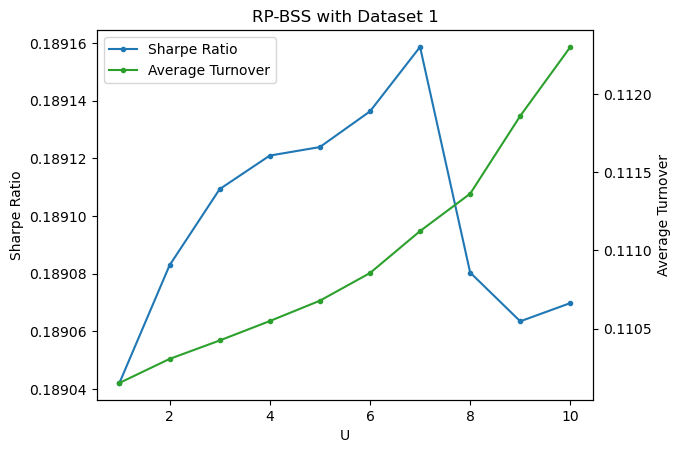

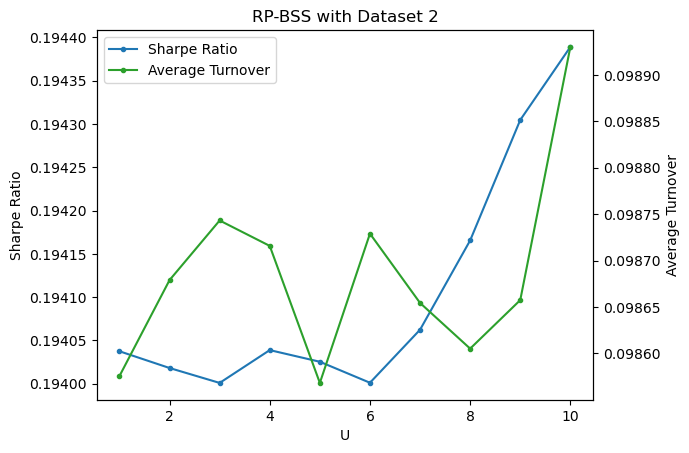

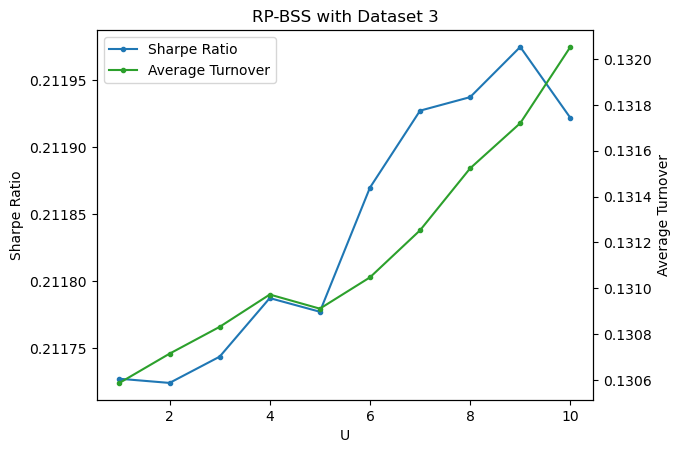

In [7]:
for i in range(1, 4):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sub_df = df[(df['Dataset'] == i)]

    ax1.plot(sub_df['Parameters'], sub_df['Sharpe Ratio'], '.-', color='tab:blue', label='Sharpe Ratio')
    ax1.plot([], [], '.-', color='tab:green', label='Average Turnover')
    ax2.plot(sub_df['Parameters'], sub_df['Average Turnover'], '.-', color='tab:green')

    ax1.legend(loc='upper left')

    plt.title('RP-BSS with Dataset {}'.format(i))
    ax1.set_xlabel('U')
    ax1.set_ylabel('Sharpe Ratio')
    ax2.set_ylabel('Average Turnover')

    plt.show()

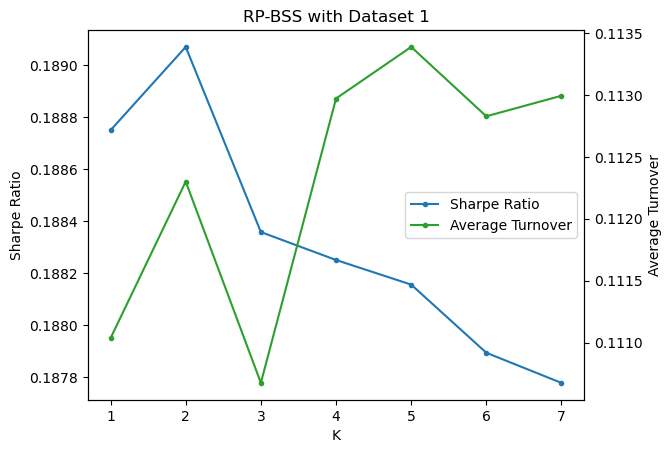

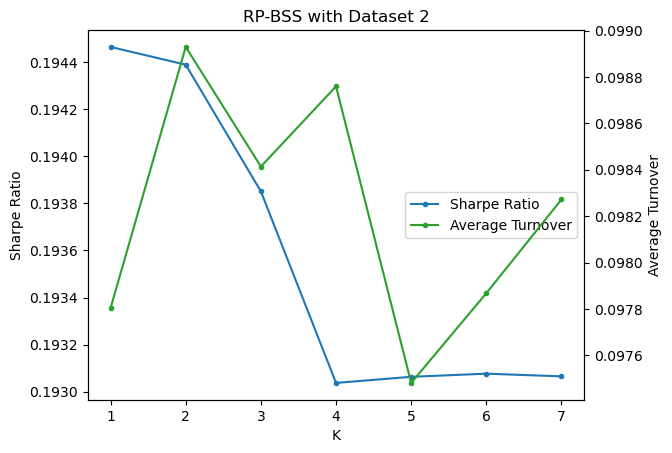

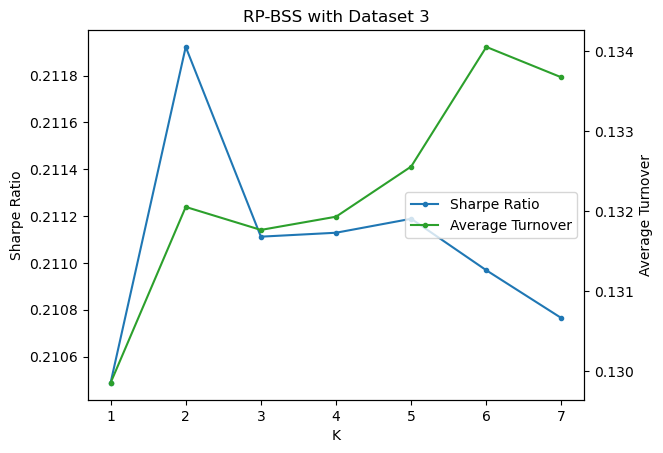

In [9]:
for i in range(1, 4):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sub_df = df[(df['Dataset'] == i)]

    ax1.plot(sub_df['Parameters'], sub_df['Sharpe Ratio'], '.-', color='tab:blue', label='Sharpe Ratio')
    ax1.plot([], [], '.-', color='tab:green', label='Average Turnover')
    ax2.plot(sub_df['Parameters'], sub_df['Average Turnover'], '.-', color='tab:green')

    ax1.legend(loc='center right')

    plt.title('RP-BSS with Dataset {}'.format(i))
    ax1.set_xlabel('K')
    ax1.set_ylabel('Sharpe Ratio')
    ax2.set_ylabel('Average Turnover')

    plt.show()

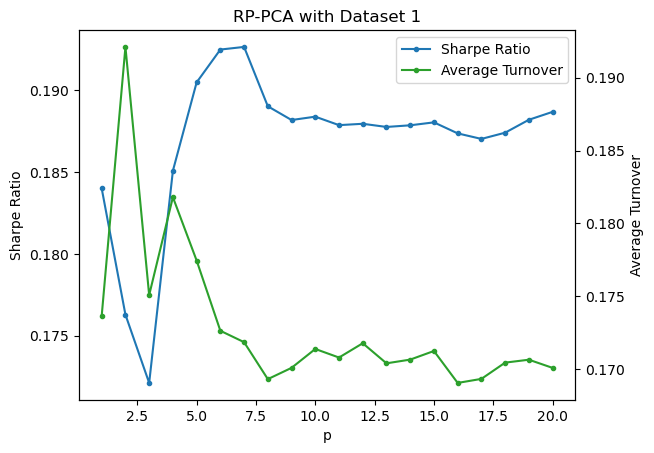

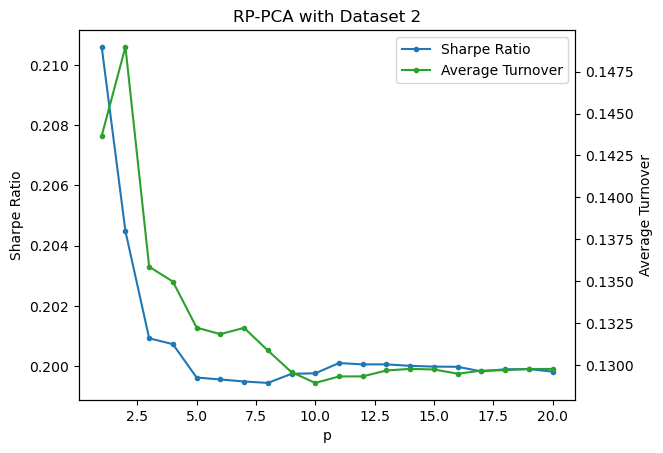

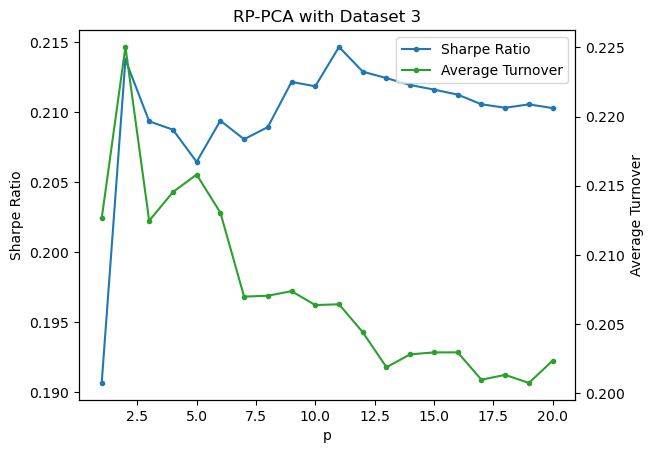

In [28]:
for i in range(1, 4):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    sub_df = df[(df['Dataset'] == i)]

    ax1.plot(sub_df['Parameters'], sub_df['Sharpe Ratio'], '.-', color='tab:blue', label='Sharpe Ratio')
    ax1.plot([], [], '.-', color='tab:green', label='Average Turnover')
    ax2.plot(sub_df['Parameters'], sub_df['Average Turnover'], '.-', color='tab:green')

    ax1.legend(loc='upper right')

    plt.title('RP-PCA with Dataset {}'.format(i))
    ax1.set_xlabel('p')
    ax1.set_ylabel('Sharpe Ratio')
    ax2.set_ylabel('Average Turnover')

    plt.show()

<Figure size 640x480 with 0 Axes>

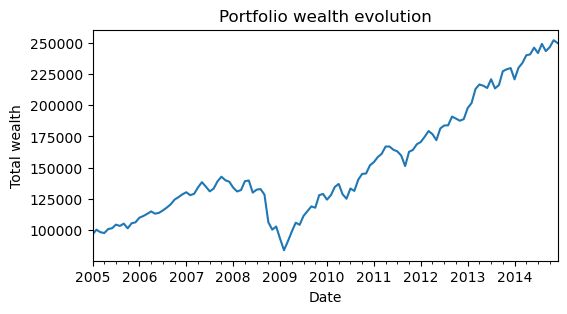

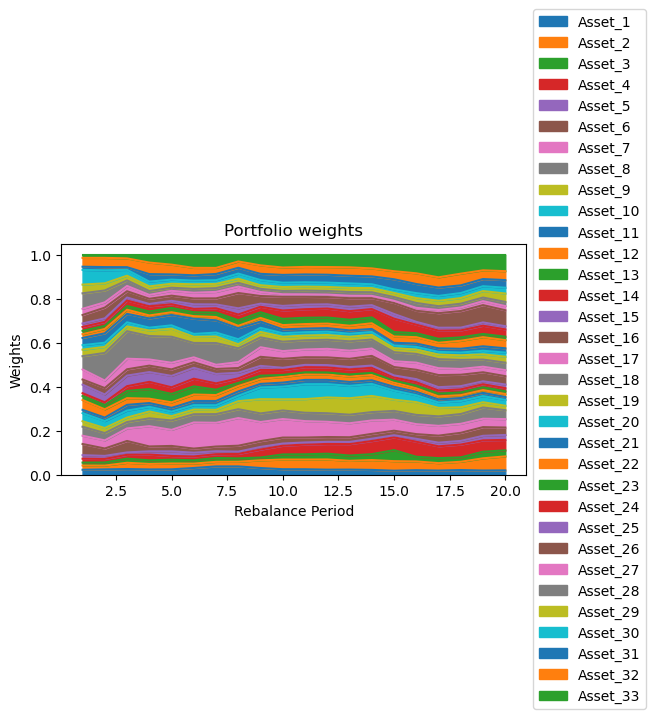

In [12]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2);
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights.T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End